In [2]:
import random
import calendar
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from deap import base, tools, creator, algorithms

In [3]:
data = pd.read_csv('employee_shift.csv')
data.sample(20)

,Employee_Name,Day_of_the_Month,Day_of_the_Week,Gender,Religion,Shift_ID
345,Putri,5,Sabtu,Perempuan,Islam,6
321,Rini,12,Sabtu,Perempuan,Islam,1
242,Sulis,26,Sabtu,Perempuan,Islam,2
248,Dzaki,1,Selasa,Laki-laki,Islam,3
385,Sri Wahyuni,14,Senin,Perempuan,Islam,2
325,Rini,16,Rabu,Perempuan,Islam,2
263,Dzaki,16,Rabu,Laki-laki,Islam,1
217,Sulis,1,Selasa,Perempuan,Islam,5
23,Dimas,24,Kamis,Laki-laki,Islam,1
82,Riza,21,Senin,Laki-Laki,Islam,6


In [4]:
# Define shift schedule (shift ID)
SHIFTS = {
    1: ("10:00 AM", "18:00 PM"),
    2: ("14:00 PM", "22:00 PM"),
    3: ("12:00 PM", "20:00 PM"),
    4: ("10:00 AM", "20:00 PM"),
    5: ("10:00 AM", "19:00 PM"),
    6: ("10:00 AM", "22:00 PM"), # Full Shift
    7: ("OFF", "OFF DAY") # Off Day
}

# Setup DEAP genetic algorithm
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [5]:
def init_individual():
    # Create a schedule for each employee, instead of a single shift
    num_employees = len(data)
    # Create a list of schedules for each employee. Each schedule is a list of 7 shifts
    return [[random.choice(list(SHIFTS.keys())) for _ in range(7)]
            for _ in range(num_employees)]

def custom_mutation(individual, indpb):
    """Custom mutation to handle integer shift IDs."""
    # Iterate through each employee's schedule
    for employee_schedule in individual:
        # Iterate through each day in the schedule
        for i in range(len(employee_schedule)):
            if random.random() < indpb:
                # Instead of flipping the bit, select a new random shift ID
                employee_schedule[i] = random.choice(list(SHIFTS.keys()))
    return individual,  # Return the modified individual as a tuple

In [6]:
# Aturan 1: Tidak boleh mengambil cuti pada akhir pekan
def rule_weekend_no_off(schedule):
    weekday_off_count = 0
    for i in range(0, 5):  # Check for Monday-Friday
        if schedule[i] == 7:
            weekday_off_count += 1
    if weekday_off_count > 1:
        return False
    return True

# Aturan 2: Shift sebelum dan setelah libur
def rule_shift_before_after_off(schedule):
    for i in range(1, len(schedule)-1):
        if schedule[i] == 7:  # Check for "OFF" day
            if schedule[i-1] not in [1, 4] or schedule[i+1] != 2:  # Before OFF must be shift 1 or 4, after must be 2
                return False
    return True

# Aturan 3: Laki-laki Muslim tidak boleh mengambil shift 1, 3, 4 pada hari Jumat
def rule_friday_shift(schedule, employee):
    friday_shift = schedule[5]  # Index 5 is Friday
    # Ensure Gender and Religion exist in the dataframe, may need to modify the columns
    # based on their actual names in your file.
    gender_col = 'Gender'  # or 'Jenis Kelamin', 'gender', etc.
    religion_col = 'Religion'  # or 'Agama', 'religion', etc.
    if gender_col in employee and religion_col in employee:
        if employee[gender_col] == 'Male' and employee[religion_col] == 'Islam' and friday_shift in [1, 3, 4]:
            return False
    return True

# Rule 4: Karyawan ditempatkan di shift 4 pada akhir pekan (Jumat hingga Minggu)
def rule_weekend_shift(schedule):
    weekend_shifts = [schedule[5], schedule[6]]  # Jumat dan Sabtu (assuming index 5 and 6 are Friday and Saturday)
    if any(shift != 4 for shift in weekend_shifts):  # Should be shift 4
        return False
    return True

# Rule 5: Minimal dua orang untuk menutup toko di shift malam (shift 6)
def rule_min_two_for_closing(schedules):
    for day in range(len(schedules[0])):  # Loop over each day
        shift_count = sum(1 for schedule in schedules if schedule[day] == 6)
        if shift_count < 2:
            return False
    return True

# Rule 6: Hindari shift pagi setelah shift malam
def rule_no_morning_after_night(schedule):
    for i in range(1, len(schedule)):
        if schedule[i-1] == 6 and schedule[i] == 1:  # If night shift followed by morning shift
            return False
    return True

# Fungsi fitness
def evaluate(individual):
    total_penalty = 0
    for idx, employee_schedule in enumerate(individual):
        employee = data.iloc[idx]  # Get employee data from dataframe
        if not rule_weekend_no_off(employee_schedule):
            total_penalty += 10
        if not rule_friday_shift(employee_schedule, employee):
            total_penalty += 20
        if not rule_shift_before_after_off(employee_schedule):
            total_penalty += 15
        if not rule_weekend_shift(employee_schedule):
            total_penalty += 10
        if not rule_min_two_for_closing(individual):
            total_penalty += 20
        if not rule_no_morning_after_night(employee_schedule):
            total_penalty += 10
    return (total_penalty,)

In [7]:
toolbox = base.Toolbox()
toolbox.register("evaluate", evaluate)
# Functions for crossover, mutation, selection
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", custom_mutation, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=5)
toolbox.register("individual", tools.initIterate, creator.Individual, init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [8]:
# Genetic algorithm parameters
population_size = 150
generations = 200
crossover_prob = 0.7
mutation_prob = 0.3

# Generate initial population
pop = toolbox.population(n=population_size)

# Create stats object
mstats = tools.Statistics(lambda ind: ind.fitness.values)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

# Create Hall of Fame object
hof = tools.HallOfFame(1) # Keep only the best individual

# Run the genetic algorithm
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=crossover_prob,
                    mutpb=mutation_prob, ngen=generations,
                    verbose=True, stats=mstats, halloffame=hof)

# Get the best individual
best_individual = tools.selBest(pop, k=1)[0]
print("Best Schedule found:", best_individual)

# Map shift IDs to actual shifts
final_schedule = []

# Iterate through each employee's schedule
for employee_schedule in best_individual:
    employee_final_schedule = []
    # Iterate through each day's shift ID in the employee's schedule
    for shift_id in employee_schedule:
        employee_final_schedule.append(SHIFTS[shift_id])
    final_schedule.append(employee_final_schedule)

gen	nevals	avg    	std   	min 	max 
0  	150   	8162.37	214.63	7520	8730
1  	126   	7926.37	174.854	7300	8305
2  	132   	7726.97	155.843	7300	8150
3  	120   	7552.57	124.662	7230	7870
4  	123   	7425.47	107.24 	7185	7700
5  	124   	7320.8 	106.374	7035	7590
6  	121   	7216.37	97.7137	6955	7480
7  	119   	7129.27	100.134	6860	7450
8  	116   	7036.13	112.674	6715	7315
9  	130   	6938.6 	112.149	6620	7220
10 	133   	6839.9 	103.876	6610	7150
11 	126   	6750.27	88.1264	6490	6975
12 	129   	6676.33	88.6748	6395	6975
13 	122   	6622.6 	105.195	6380	6890
14 	122   	6536.27	83.363 	6335	6820
15 	115   	6487.97	95.3749	6235	6740
16 	115   	6429.2 	89.8741	6235	6845
17 	122   	6373.03	88.1361	6225	6615
18 	126   	6321.63	85.5132	6180	6585
19 	109   	6280.73	81.6402	6120	6520
20 	118   	6252.6 	79.6089	6120	6535
21 	120   	6221.47	83.7089	6085	6485
22 	113   	6188   	83.7616	6065	6460
23 	115   	6157.93	94.6012	6010	6510
24 	127   	6108.33	74.2039	5950	6380
25 	123   	6086.67	91.8162	5890	6360
26 

In [9]:
print(final_schedule)

[[('14:00 PM', '22:00 PM'), ('10:00 AM', '18:00 PM'), ('10:00 AM', '22:00 PM'), ('14:00 PM', '22:00 PM'), ('10:00 AM', '22:00 PM'), ('14:00 PM', '22:00 PM'), ('10:00 AM', '22:00 PM')], [('12:00 PM', '20:00 PM'), ('10:00 AM', '20:00 PM'), ('10:00 AM', '18:00 PM'), ('10:00 AM', '19:00 PM'), ('10:00 AM', '20:00 PM'), ('10:00 AM', '20:00 PM'), ('12:00 PM', '20:00 PM')], [('OFF', 'OFF DAY'), ('14:00 PM', '22:00 PM'), ('14:00 PM', '22:00 PM'), ('10:00 AM', '22:00 PM'), ('10:00 AM', '22:00 PM'), ('10:00 AM', '22:00 PM'), ('OFF', 'OFF DAY')], [('OFF', 'OFF DAY'), ('12:00 PM', '20:00 PM'), ('10:00 AM', '19:00 PM'), ('10:00 AM', '18:00 PM'), ('10:00 AM', '22:00 PM'), ('14:00 PM', '22:00 PM'), ('10:00 AM', '19:00 PM')], [('12:00 PM', '20:00 PM'), ('10:00 AM', '22:00 PM'), ('10:00 AM', '20:00 PM'), ('OFF', 'OFF DAY'), ('10:00 AM', '18:00 PM'), ('14:00 PM', '22:00 PM'), ('12:00 PM', '20:00 PM')], [('10:00 AM', '19:00 PM'), ('10:00 AM', '19:00 PM'), ('10:00 AM', '19:00 PM'), ('12:00 PM', '20:00 PM')

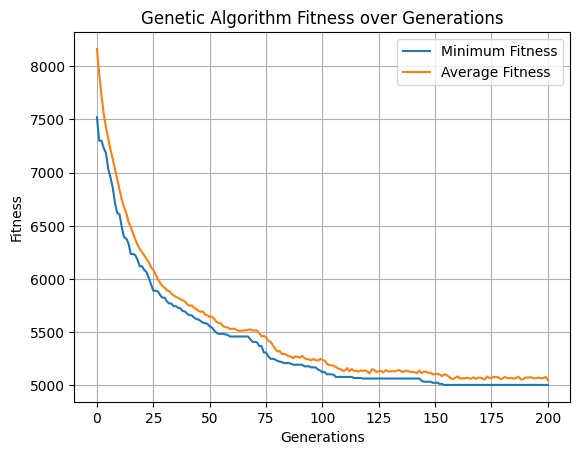

In [10]:
# Extract the fitness values from the logbook
min_fitness_values = [x['min'] for x in logbook]
avg_fitness_values = [x['avg'] for x in logbook]

# Plot the fitness values
plt.plot(min_fitness_values, label='Minimum Fitness')
plt.plot(avg_fitness_values, label='Average Fitness')
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title('Genetic Algorithm Fitness over Generations')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
print("Best individual is: %s, %s" % (hof[0], hof[0].fitness))

Best individual is: [[2, 1, 6, 2, 6, 2, 6], [3, 4, 1, 5, 4, 4, 3], [7, 2, 2, 6, 6, 6, 7], [7, 3, 5, 1, 6, 2, 5], [3, 6, 4, 7, 1, 2, 3], [5, 5, 5, 3, 6, 7, 4], [3, 2, 3, 4, 2, 1, 3], [5, 5, 3, 4, 3, 4, 4], [5, 4, 4, 4, 2, 1, 7], [4, 3, 5, 2, 5, 7, 1], [2, 4, 6, 7, 5, 4, 4], [4, 3, 6, 4, 7, 2, 4], [2, 5, 1, 6, 5, 3, 5], [1, 7, 2, 2, 1, 5, 2], [2, 6, 5, 4, 2, 7, 1], [4, 6, 4, 2, 1, 6, 7], [4, 5, 4, 5, 4, 2, 1], [5, 3, 6, 3, 4, 7, 2], [3, 5, 5, 4, 6, 5, 5], [3, 4, 1, 6, 2, 2, 4], [7, 1, 3, 5, 2, 6, 5], [4, 6, 4, 1, 6, 6, 2], [2, 4, 3, 4, 2, 3, 4], [6, 3, 5, 6, 2, 5, 5], [6, 2, 7, 7, 2, 7, 6], [6, 3, 4, 2, 1, 1, 2], [5, 4, 6, 4, 2, 7, 3], [7, 7, 7, 3, 2, 2, 1], [1, 2, 2, 3, 4, 3, 4], [6, 5, 4, 2, 6, 3, 3], [1, 2, 6, 2, 1, 4, 1], [7, 2, 2, 5, 6, 1, 3], [7, 6, 3, 1, 4, 6, 2], [1, 2, 5, 2, 5, 5, 1], [6, 4, 4, 7, 5, 6, 2], [4, 5, 2, 3, 4, 3, 2], [7, 6, 6, 4, 4, 4, 4], [6, 2, 1, 6, 3, 4, 1], [5, 4, 4, 2, 4, 2, 3], [7, 4, 1, 6, 1, 4, 4], [1, 4, 1, 1, 4, 1, 2], [1, 1, 5, 4, 1, 4, 4], [4, 6, 3, 3, 

In [12]:
# Create a list to store the data for the new dataframe
employee_data = []

# Iterate through each employee's schedule in the best individual
for employee_index, employee_schedule in enumerate(best_individual):
  employee_name = data.iloc[employee_index][0]  # Assuming the name is in the first column
  # Assuming 'SHIFTS' is a dictionary mapping shift IDs to their values
  schedule_details = []
  for day, shift_id in enumerate(employee_schedule):
    start_time, end_time = SHIFTS[shift_id]  # Get shift start and end times
    day_name = calendar.day_name[(datetime.now().weekday() + day) % 7]  # Calculate day name
    schedule_details.append({
        'Day': day_name,
        'Shift': (start_time, end_time)  # Store shift as a tuple or another suitable format
    })
  employee_data.append({
      'Employee': employee_name,
      'Schedule': schedule_details
  })

# Convert the list to a dataframe
result_df = pd.DataFrame(employee_data)
result_df

# Save the dataframe to a CSV file
result_df.to_csv('schedule_result_5.csv', index=False)

C:\Users\hendr\AppData\Local\Temp\ipykernel_17180\4052218462.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  employee_name = data.iloc[employee_index][0]  # Assuming the name is in the first column
